<a href="https://colab.research.google.com/github/AgnieszkaBlok/autocoder-cats/blob/main/Autokoder_z_odtwarzaniem_brakuj%C4%85cych_fragment%C3%B3w_obraz%C3%B3w_zwierz%C4%85t_(inpainting).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autokoder z odtwarzaniem brakujących fragmentów obrazów zwierząt (inpainting)
Celem tego notatnika jest opracowanie procedury złożonej z przetwarzania wstępnego oraz modelu autokodera z odtwarzaniem brakujących fragmentów obrazów zwierząt (inpainting).

Autor: Agnieszka Blok

##Przygotowanie danych

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
from PIL import Image
from google.colab import drive

drive.mount('/content/drive')
data_dir =  "/content/drive/MyDrive/dataset-part1"
print("Zawartość katalogu:")
print(os.listdir(data_dir))



Mounted at /content/drive
Zawartość katalogu:
['cat_3805 (1).png', 'cat_3501.png', 'cat_3802.png', 'cat_3122.png', 'cat_3074.png', 'cat_3717.png', 'cat_3781.png', 'cat_3604.png', 'cat_3082.png', 'cat_3741.png', 'cat_2973.png', 'cat_3734.png', 'cat_3601.png', 'cat_3476.png', 'cat_2798.png', 'cat_3780.png', 'cat_3694.png', 'cat_3431.png', 'cat_3628.png', 'cat_2940.png', 'cat_3205.png', 'cat_3009.png', 'cat_3071.png', 'cat_2830.png', 'cat_2943.png', 'cat_3812.png', 'cat_3358.png', 'cat_3680.png', 'cat_3061.png', 'cat_3003.png', 'cat_3186.png', 'cat_3241.png', 'cat_3457.png', 'cat_3424.png', 'cat_2691.png', 'cat_3410.png', 'cat_3062.png', 'cat_2690.png', 'cat_3558.png', 'cat_3087.png', 'cat_3847.png', 'cat_3411.png', 'cat_2937.png', 'cat_3010.png', 'cat_3545.png', 'cat_3724.png', 'cat_3566.png', 'cat_3160.png', 'cat_3113.png', 'cat_3311.png', 'cat_3689.png', 'cat_3850.png', 'cat_3192.png', 'cat_2833.png', 'cat_3512.png', 'cat_3210.png', 'cat_3657.png', 'cat_3652.png', 'cat_2705.png', 'cat_

In [ ]:
image_size = 64

mask_fraction = 0.25

def load_images(data_dir, image_size):
    images = []
    for filename in os.listdir(data_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(data_dir, filename)
            img = load_img(img_path, target_size=(image_size, image_size), color_mode="grayscale")
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
    return np.array(images)

images = load_images(data_dir, image_size)

x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

print(f"Rozmiar zbioru treningowego: {x_train.shape}")
print(f"Rozmiar zbioru testowego: {x_test.shape}")


Rozmiar zbioru treningowego: (2572, 64, 64, 1)
Rozmiar zbioru testowego: (643, 64, 64, 1)


##Generowanie Masek


Maski są generowane w trakcie uczenia w kształcie prostokątnym, kwadraowym, nieregularnych plam.

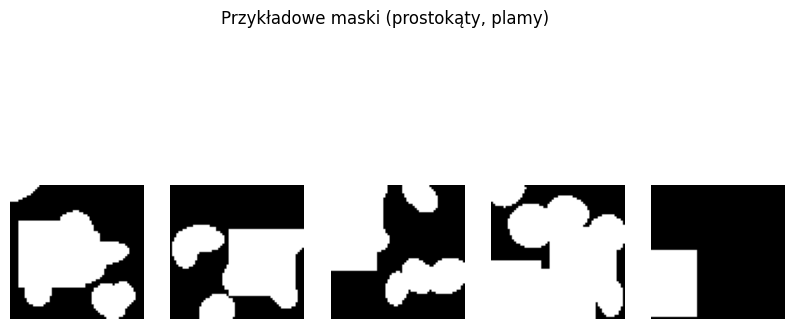

In [ ]:
import cv2
def generate_rectangle_mask(image_shape, mask_fraction=0.25):
    height, width = image_shape[:2]
    mask = np.zeros((height, width), dtype=np.float32)
    rect_height = int(np.sqrt(mask_fraction * height * width))
    rect_width = rect_height
    rect_height = min(rect_height, height)
    rect_width = min(rect_width, width)
    y = np.random.randint(0, height - rect_height+1)
    x = np.random.randint(0, width - rect_width+1)
    mask[y:y + rect_height, x:x + rect_width] = 1
    return mask

def generate_irregular_mask(image_shape, mask_fraction=0.25):
    height, width = image_shape[:2]
    mask = np.zeros((height, width), dtype=np.float32)
    num_shapes = np.random.randint(1, 4)
    for _ in range(num_shapes):
        x = np.random.randint(0, width)
        y = np.random.randint(0, height)
        radius = int(np.sqrt(mask_fraction * height * width) / 2)
        y1, y2 = max(0, y - radius), min(height, y + radius)
        x1, x2 = max(0, x - radius), min(width, x + radius)
        mask[y1:y2, x1:x2] = 1
    return mask

def generate_blob_mask(image_shape, mask_fraction=0.25):

    height, width = image_shape[:2]
    mask = np.zeros((height, width), dtype=np.float32)

    total_mask_area = int(mask_fraction * height * width)

    current_area = 0
    while current_area < total_mask_area:

        x_center = np.random.randint(0, width)
        y_center = np.random.randint(0, height)

        radius_x = np.random.randint(5, int(width * 0.2))
        radius_y = np.random.randint(5, int(height * 0.2))
        angle = np.random.randint(0, 360)

        overlay = np.zeros((height, width), dtype=np.uint8)
        cv2.ellipse(overlay, (x_center, y_center), (radius_x, radius_y), angle, 0, 360, 255, -1)

        mask += overlay / 255.0
        current_area = np.sum(mask > 0)

    mask = np.clip(mask, 0, 1)
    return mask

def generate_dynamic_fraction_mask(image_shape):
    mask_fraction = np.random.uniform(0.1, 0.4)
    return generate_combined_mask_with_blobs(image_shape, mask_fraction)


def generate_combined_mask_with_blobs(image_shape, mask_fraction=0.25):

    height, width = image_shape[:2]
    mask = np.zeros((height, width), dtype=np.float32)

    if np.random.rand() > 0.35:
        mask += generate_rectangle_mask(image_shape, mask_fraction)
    else:
        mask += generate_irregular_mask(image_shape, mask_fraction)

    if np.random.rand() > 0.35:
        mask += generate_blob_mask(image_shape, mask_fraction)

    return np.clip(mask, 0, 1)


def generate_masks_for_dataset(dataset, mask_fraction=0.25, mask_type="combined_with_blobs"):
    masks = []
    for img in dataset:
          if mask_type == "rectangle":
              mask = generate_rectangle_mask(img.shape, mask_fraction)
          elif mask_type == "irregular":
              mask = generate_irregular_mask(img.shape, mask_fraction)
          else:
              mask = generate_combined_mask_with_blobs(img.shape, mask_fraction)
          masks.append(mask)
    return np.expand_dims(np.array(masks), axis=-1)


mask_train = generate_masks_for_dataset(x_train, mask_fraction=0.25, mask_type="combined_with_blobs")
mask_test = generate_masks_for_dataset(x_test, mask_fraction=0.25, mask_type="combined_with_blobs")

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(mask_train[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Przykładowe maski (prostokąty, plamy)")
plt.show()


##Autokoder

In [ ]:
def build_autoencoder(input_shape):
    inputs = Input(shape=input_shape)

    # Kodowanie
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', strides=2)(x)

    # Dekodowanie
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs, outputs)

input_shape = (image_size, image_size, 1)
autoencoder = build_autoencoder(input_shape)
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss=MeanSquaredError())

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,251,073 (8.59 MB)

 Trainable params: 2,251,073 (8.59 MB)

 Non-trainable params: 0 (0.00 B)

##Trening

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
x_train_masked = x_train * (1 - mask_train)
x_test_masked = x_test * (1 - mask_test)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = autoencoder.fit(
    x_train_masked, x_train,
    validation_data=(x_test_masked, x_test),
    epochs=60,
    batch_size=32,
    callbacks=[early_stopping]
)
autoencoder.save('autoencoder_model_4.h5')


Epoch 1/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - loss: 0.0503 - val_loss: 0.0212
Epoch 2/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - loss: 0.0194 - val_loss: 0.0168
Epoch 3/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - loss: 0.0162 - val_loss: 0.0158
Epoch 4/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - loss: 0.0147 - val_loss: 0.0156
Epoch 5/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - loss: 0.0141 - val_loss: 0.0150
Epoch 6/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - loss: 0.0145 - val_loss: 0.0148
Epoch 7/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - loss: 0.0135 - val_loss: 0.0140
Epoch 8/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - loss: 0.0131 - val_loss: 0.0140
Epoch 9/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - loss: 0.0128 - val_loss: 0.0131
Epoch 10/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - loss: 0.0126 - val_loss: 0.0129
Epoch 11/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - loss: 0.0121 - val_loss: 0.0129
Epoch 12/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - loss: 0.0

##Walidacja i wizualizacja

21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 526ms/step


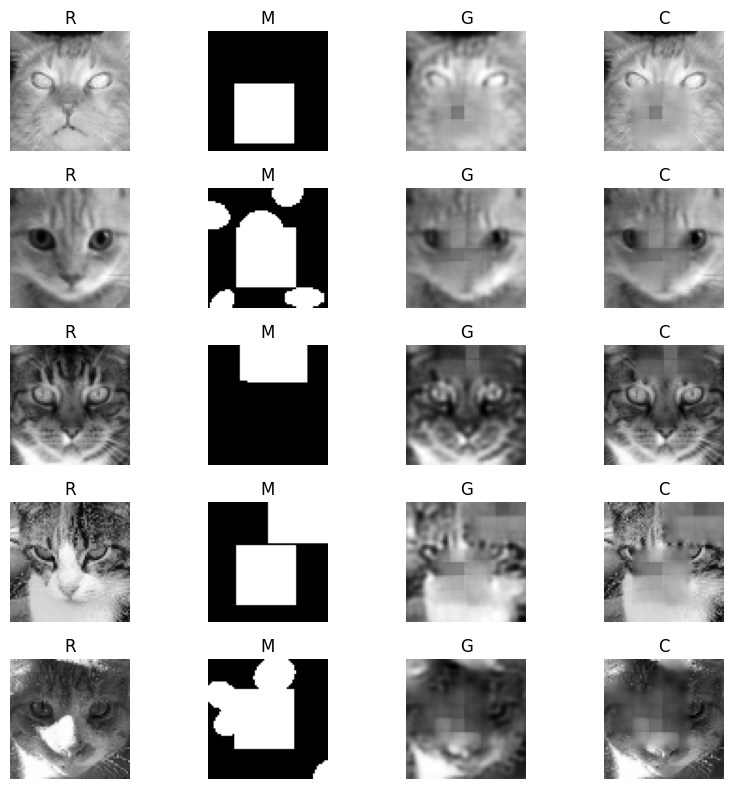

In [ ]:
reconstructed = autoencoder.predict(x_test_masked)

final_results = x_test * (1 - mask_test) + reconstructed * mask_test

plt.figure(figsize=(16, 8))
for i in range(5):
    plt.subplot(5, 8, i * 8 + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("R")
    plt.axis('off')

    plt.subplot(5, 8, i * 8 + 2)
    plt.imshow(mask_test[i].squeeze(), cmap='gray')
    plt.title("M")
    plt.axis('off')

    plt.subplot(5, 8, i * 8 + 3)
    plt.imshow(reconstructed[i].squeeze(), cmap='gray')
    plt.title("G")
    plt.axis('off')

    plt.subplot(5, 8, i * 8 + 4)
    plt.imshow(final_results[i].squeeze(), cmap='gray')
    plt.title("C")
    plt.axis('off')
plt.tight_layout()
plt.show()


##Test


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


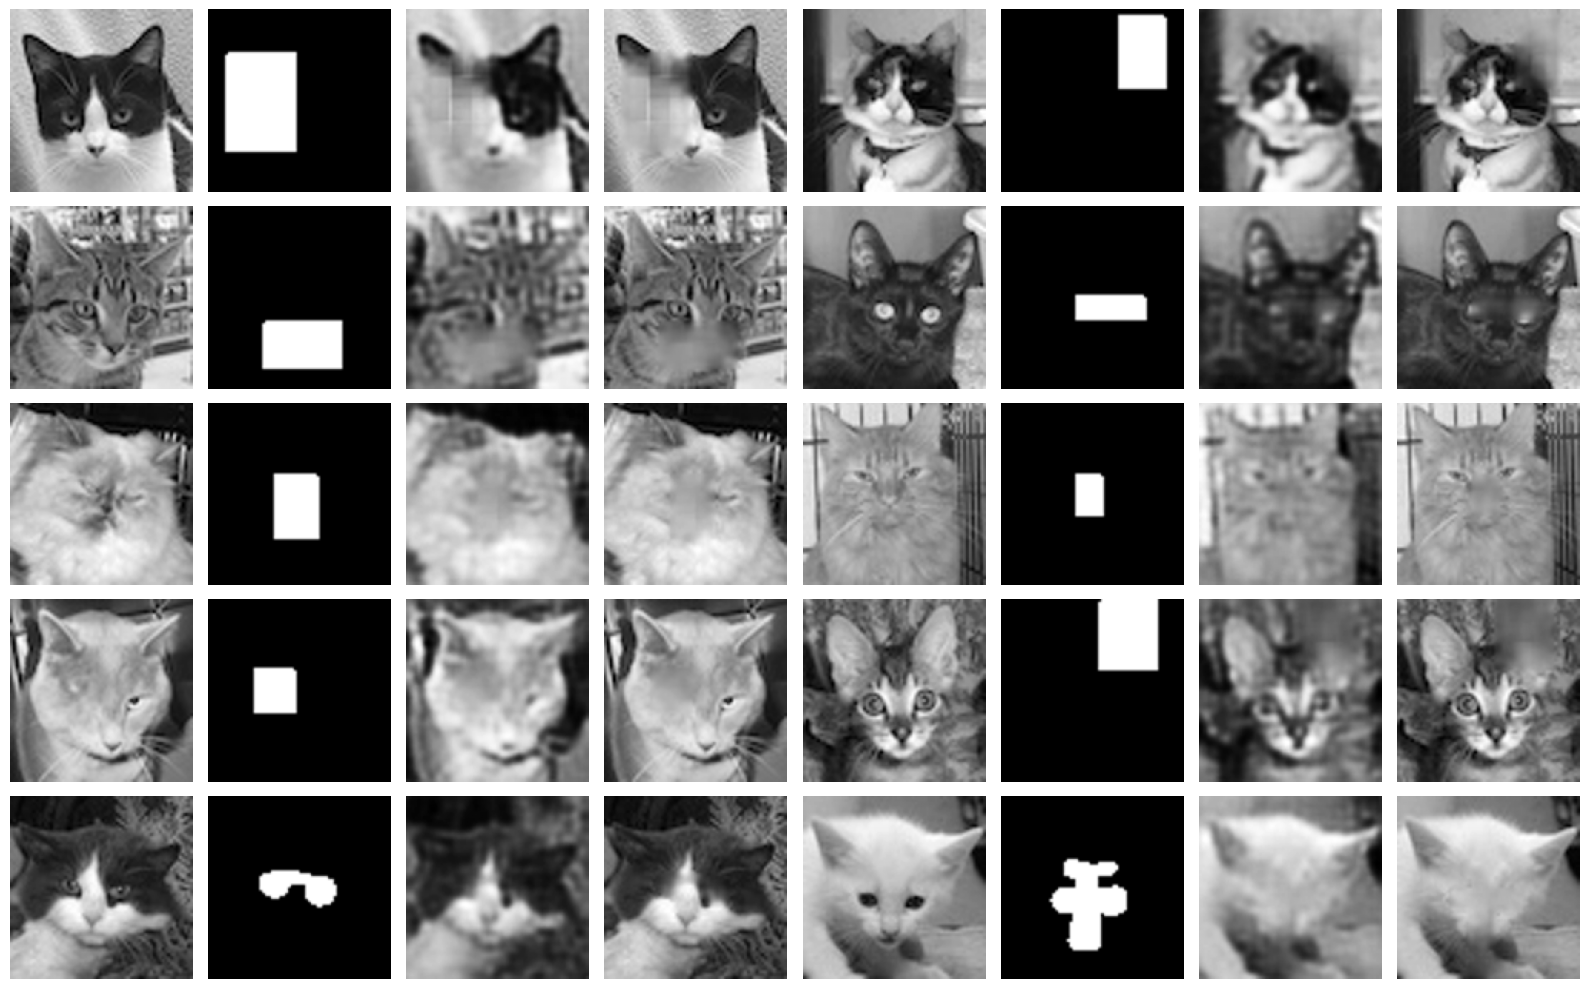

In [ ]:
def load_and_preprocess_image(image_path, target_size=(64, 64)):
    image = Image.open(image_path).convert('L')
    image = image.resize(target_size)
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=-1)
    return image

def load_and_preprocess_mask(mask_path, target_size=(64, 64)):
    mask = Image.open(mask_path).convert('L')
    mask = mask.resize(target_size)
    mask = np.array(mask)
    mask = np.where(mask < 128, 0, 1).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

test_images_path = '/content/test_images'
test_masks_path = '/content/test_mask'

test_images = []
test_masks = []
for file_name in sorted(os.listdir(test_images_path)):
    image_path = os.path.join(test_images_path, file_name)
    mask_path = os.path.join(test_masks_path, file_name)
    test_images.append(load_and_preprocess_image(image_path))
    test_masks.append(load_and_preprocess_mask(mask_path))

test_images = np.array(test_images)
test_masks = np.array(test_masks)

reconstructed_images = autoencoder.predict(test_images * (1 - test_masks))

final_images = []
for i in range(len(test_images)):
    original = test_images[i]
    mask = test_masks[i]
    generated = reconstructed_images[i]

    composite = original * (1 - mask) + generated * mask
    final_images.append(composite)

def resize_for_display(image, size=(128, 128)):
    image = (image * 255).astype(np.uint8)
    image = Image.fromarray(image.squeeze(), mode='L')
    image = image.resize(size)
    return np.array(image)

fig, axes = plt.subplots(5, 8, figsize=(16, 10))
axes = axes.flatten()

for i in range(5):
    for j in range(8):
        idx = i * 2 + (j // 4)
        if j % 4 == 0:
            image = resize_for_display(test_images[idx])
        elif j % 4 == 1:
            image = resize_for_display(test_masks[idx])
        elif j % 4 == 2:
            image = resize_for_display(reconstructed_images[idx])
        elif j % 4 == 3:
            image = resize_for_display(final_images[idx])

        axes[i * 8 + j].imshow(image, cmap='gray')
        axes[i * 8 + j].axis('off')

plt.tight_layout()
plt.show()
